In [1]:
import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
# 15-Sep-2019
# Bo Milvang-Jensen
# Very rudimentary script to read+plot ...

import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt

# Read photometry catalogue created by my other script
photfilename = 'F51_out_REMIR_ROS2.fits'
data = fits.getdata(photfilename, 1)

# The photometry catalogue contains aperture photometry in 25 different
# apertures. If we number them 0..24, they correspond to diameters 1..25 arcsec
apno = 10 # This is then 11 arcsec

# The photometry catalogue contains photometry for the AGN plus some more
# objects in the field, in this case the AGN + 6 more objetcs, so 7 in
# total. The AGN is number 1, and the others 2, 3, etc.
# This is seen in the column names, which end in _1, _2, etc.
# E.g. the column MAG_APER_1 contains the aperture magnitudes (for all
# 25 apertures) for the AGN.

# Get the aperture magnitudes
##foo = data['MAG_APER_1'] # has shape e.g. (767, 25), the 25 being the apertures
mag_agn  = data['MAG_APER_1'][:,apno]
mag_ref1 = data['MAG_APER_3'][:,apno] # I have found that _3 is good here
mag_ref2 = data['MAG_APER_4'][:,apno]

# Get the differential magnitudes
delta_mag_agn_ref1 = mag_agn - mag_ref1
delta_mag_ref2_ref1 = mag_ref2 - mag_ref1

# Get the magnitude errors 
magerr_agn = data['MAGERR_APER_1'][:,apno]
magerr_ref1 = data['MAGERR_APER_3'][:,apno]
magerr_ref2= data['MAGERR_APER_4'][:,apno]

# TODO Here I could loop over the filters, subtracting the median

# For simplicity "extract" some arrays from the data
filt = data['filter']
mjd_obs = data['mjd_obs']

# A simple plot of the J band differential mags, with the median subtracted
# Do 'H' and 'K' in the same way
mask = (filt == 'J')
#print(magerr_ref1[mask])
#plt.scatter(mjd_obs[mask], delta_mag_agn_ref1[mask]-np.median(delta_mag_agn_ref1[mask]))
plt.errorbar(mjd_obs[mask], delta_mag_agn_ref1[mask]-np.median(delta_mag_agn_ref1[mask]), magerr_ref1[mask],fmt='b.')
plt.title('test')
plt.xlabel('MJD-OBS')
plt.ylabel('delta mag')
plt.show()

<Figure size 640x480 with 1 Axes>

In [2]:
x=np.asarray(mjd_obs[mask], dtype=float)
y=np.asarray(delta_mag_agn_ref1[mask]-np.median(delta_mag_agn_ref1[mask]), dtype=float)
yerr = magerr_ref1[mask]
n=len(x)
#test2=[57690.156444, 57702.042152,57714.09288,57727.058406,57785.33735,57799.337204,57835.345248,57847.218598,57870.38101,57872.34736,57887.334724,57901.294798,57913.261906,57925.123674,57937.187432,57949.16307,57962.127284,57974.094412,57987.048386,58000.303966,58018.23316,58047.208566,58072.050364,58084.055702,58127.353694,58151.287814,58166.326436,58183.323268,58222.31519,58236.377956,58237.3749525,58250.340886,58263.305154,58276.365486,58289.241552,58307.182884,58320.122346,58332.115664,58344.081428,58356.048366,58368.331064,58380.28918,58433.114668,58445.050324,58458.058774,58517.347406,58529.33535,58541.3453,58569.380416]
#X = np.array(test2)#np.linspace(min(x), max(x), n)[:, None]
X = np.reshape(x,(n,1))

#print(X.shape)
#Just a plot to see if i have reshaped the data correctly 
#fig = plt.figure(figsize=(12,5)); ax = fig.gca()
#plt.plot(x,y,'.')
#plt.plot(X,y,'*')

In [5]:
#We specify the prior distribution for the model parameters as normal distributions after the
#Kelly 2009 values. Kelly does write that the priors should be uniform, but the Stan people write that
#this is a bad idea and that something like a normal distributions should be used instead. 

#Sadly Skielboe et al. 2015 does not write up their priors for the model parameters.

#ℓ is related to ℓ_true by ℓ_true=2*ℓ^2, where ℓ_true is the typical timescale of variations.
#I use the result from Kelly 2009 where the range for ℓ_true is 10<ℓ_true<10^4 days with a true
#dispersion likely around 0.3 dex. I calculate the ℓ mean and sigma prior values from the ℓ_true values. 
#Maybe i should try a uniform prior here as well though the values found in Kelly 2009 are not uniform.

#η is what Skielboe et al. 2015 call σ and it is the long-term standard deviation. 
#Using a normal distribution with the mean as the standard deviation of the data and sigma as a guess.
#i get negative stdev values. i tried a uniform prior between 0 and 1 that seems to work. 
#A Halfnormal distribution also gives the same result.

#σ is the noise scale in the data such that if y is the observed values and f(x) is the underlying 
#unknown function, then y=f(x)+epsilon where the noise epsilon is Gaussian. 
#This value is the most confusing to me. 
#How do we determine the scale of the Gaussian white noise? Is it white noise at all for us?
#Kelly 2009 writes that there is a epsilon(t) white noise process with zero mean and variance equal
#to 1 and it is assumed that this process is also Gaussian. I apply a halfnormal distribution to the
#noise with the scale specified by the variance as sigma=sqrt(pi/(pi-2))*sqrt(Var) where Var=1 in our case.

#A uniform prior is given by something like pm.Uniform('parameter', lower=-10, upper=5)

with pm.Model() as model:
    ℓ = pm.Uniform('ℓ', lower=np.sqrt(5.0), upper=6.0*50.0*np.sqrt(2.0)) #pm.Normal("ℓ", mu=16.0, sigma=1.0) #the mean and sigma values here are rounded off. 
    η = pm.Uniform('η', lower=0.0, upper=1.0)#pm.Normal("η", mu=np.std(y), sigma=0.02) #pm.HalfCauchy("η", beta=0.5)

    cov = η**2 * pm.gp.cov.Exponential(1, ℓ)#i could add a alpha parameter here to take different PSD slopes into account.
    gp = pm.gp.Latent(cov_func=cov)#we might want to implement a constant mean function here
    #with the long term mean as the mean of the data points (0.0015780001270527743) instead of zero.
    
    f = gp.prior("f", X=X)
    
    k = pm.Uniform('k', lower=1.0, upper=2.0)#pm.HalfNormal("σ", sigma=np.sqrt(np.pi/(np.pi-2)))#pm.HalfCauchy("σ", beta=0.5)
    
    y_ = pm.Normal("y", mu=f, sd=k*yerr, observed=y)
    #mp = pm.find_MAP() #The Maximum A Posteriori values
    trace = pm.sample(2000) #The NUTS sampling 

ValueError: setting an array element with a sequence.

In [17]:
pm.summary(trace, ["ℓ","η","σ"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
ℓ,111.867792,109.659524,4.988897,6.575158,362.828656,380.349929,1.000045
η,0.152154,0.072579,0.003594,0.063136,0.302200,297.156869,1.000028
σ,1.320702,0.987858,0.010165,0.000463,3.207867,9855.220668,1.000116


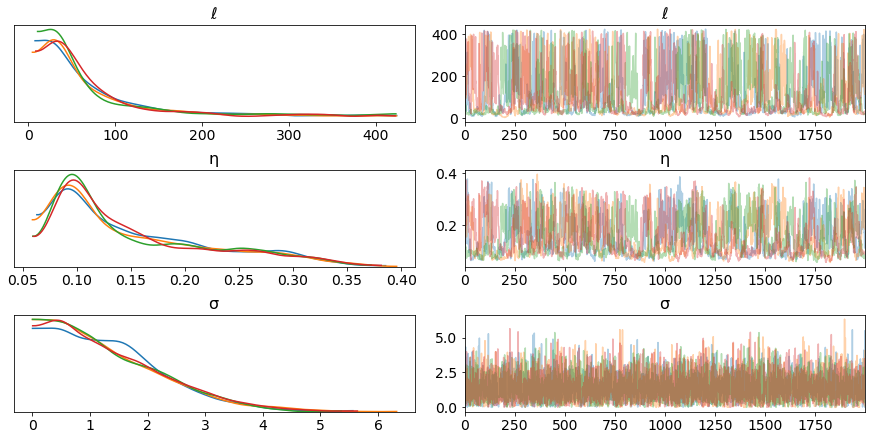

In [9]:
lines = ["ℓ","η","σ"]
pm.traceplot(trace, var_names=["ℓ","η","σ"]);
#,

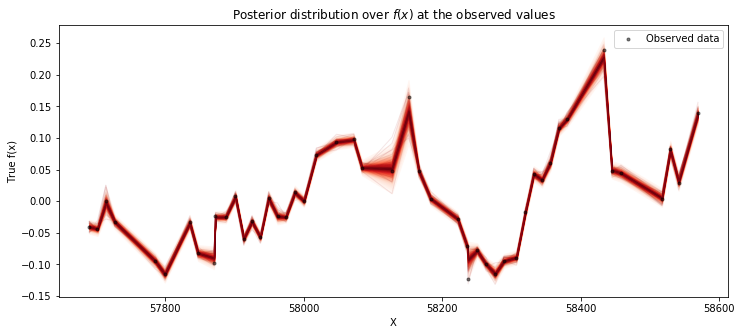

In [10]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, trace["f"], X);

# plot the data and the true latent function
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("X"); plt.ylabel("True f(x)");
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

In [12]:
# 200 new values from x=0 to x=15
n_new = 500
X_new = np.linspace(min(X), max(X), n_new)

# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", X_new)

# Sample from the GP conditional distribution
with model:
    pred_samples = pm.sample_posterior_predictive(trace, vars=[f_pred], samples=1000)

100%|██████████| 1000/1000 [01:44<00:00,  9.61it/s]


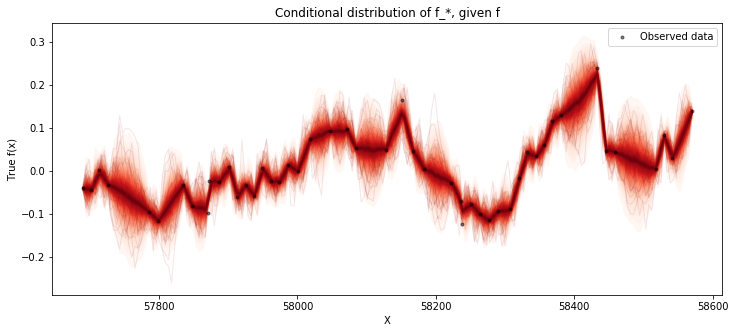

In [13]:
# plot the results

fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp_dist(ax, pred_samples["f_pred"], X_new);
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.xlabel("X"); plt.ylabel("True f(x)");
plt.title("Conditional distribution of f_*, given f"); plt.legend();

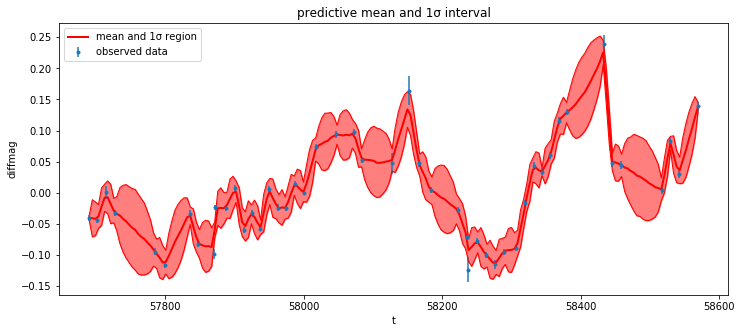

In [16]:
#Calculate the mean and standard deviation of the traces. 
mu = np.zeros(len(X_new))
sd = np.zeros(len(X_new))
w=1/(np.interp(X_new,X[:,0],yerr)**2) 

for i in range(0,len(X_new)):
    mu[i] = np.mean(pred_samples["f_pred"][:,i])
    sd[i] = np.std(pred_samples["f_pred"][:,i])

#mu=np.sum(mu*w[:,0])/np.sum(w[:,0])
#sd=np.sum(sd*w[:,0])/np.sum(w[:,0])

# draw plot
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot mean and 1σ intervals
plt.plot(X_new, mu, 'r', lw=2, label="mean and 1σ region");
plt.plot(X_new, mu + 1*sd, 'r', lw=1); plt.plot(X_new, mu - 1*sd, 'r', lw=1);
plt.fill_between(X_new.flatten(), mu - 1*sd, mu + 1*sd, color="r", alpha=0.5)

# plot original data and true function
#plt.plot(X, y, 'ok', ms=3, alpha=1.0, label="observed data")
plt.errorbar(X, y, yerr,fmt='.',label="observed data")

plt.xlabel("t");
plt.ylabel("diffmag")
plt.title("predictive mean and 1σ interval"); plt.legend();